<a href="https://colab.research.google.com/github/th4ruka/machine-learning/blob/main/models/gans/dc_gans/01_DCGAN_celebFaces_gray_64x64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import CelebFaces Dataset

In [1]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:34<00:00, 43.9MB/s]
100% 1.33G/1.33G [00:34<00:00, 40.8MB/s]


In [2]:
!unzip celeba-dataset.zip #unzip dataset

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

### Create ImageDataGenerator

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    'img_align_celeba',
    # target_size=(int(178/2), int(218/2)), #original size= 178x218
    target_size = (64,64),
    color_mode='grayscale',
    batch_size=256,
    class_mode=None,
    shuffle=True)

Found 202599 images belonging to 1 classes.


In [5]:
BUFFER_SIZE = 202599
BATCH_SIZE = 256

### View some sample data

In [6]:
x_batch = train_generator.next()

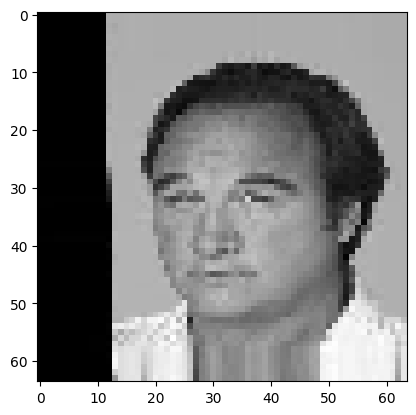

In [7]:
import matplotlib.pyplot as plt
plt.imshow(x_batch[0], cmap="gray")
plt.show()

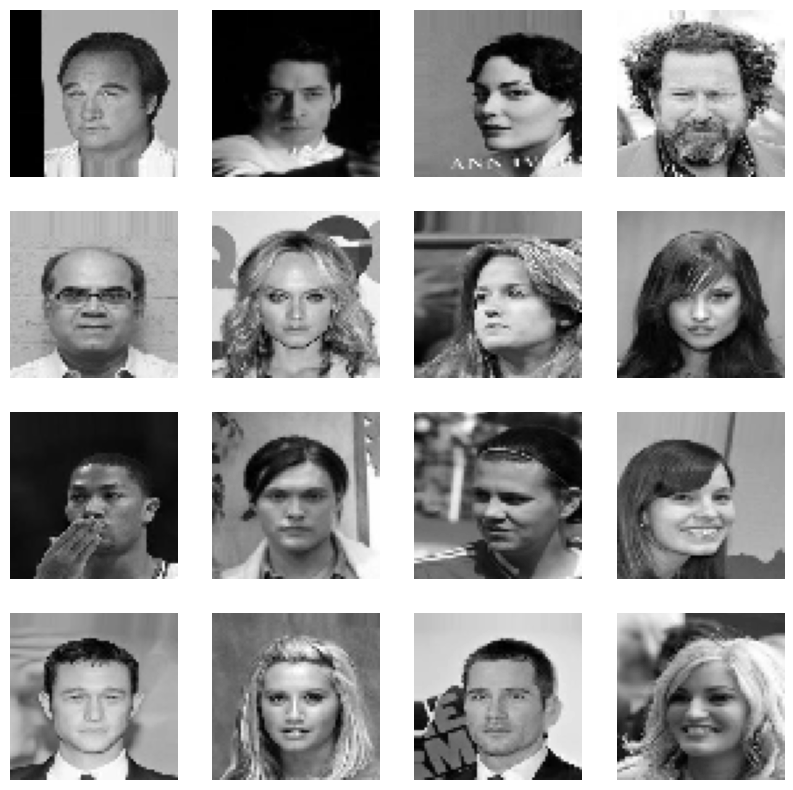

In [8]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_batch[i], cmap="gray")
    plt.axis('off')
plt.show()

## Create Models

In [9]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Generator Model

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    #The reason for this specific number of neurons is to produce a 16x16x256 tensor from a 1D input vector.
    #This will be reshaped into a 3D tensor in the subsequent layers.
    #input shape is a 1D vector of 100 elements. (Latent vector)
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) #bias is not necessary since we use batch normalization (similar benefits)
    model.add(layers.LeakyReLU()) # non linearity

    #Reshapes this flat vector into a 3D tensor with dimensions 7x7x256. This forms the initial "image"
    model.add(layers.Reshape((16, 16, 256))) #height x width x number of channels (feature maps)
    assert model.output_shape == (None, 16, 16, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 1)

    return model

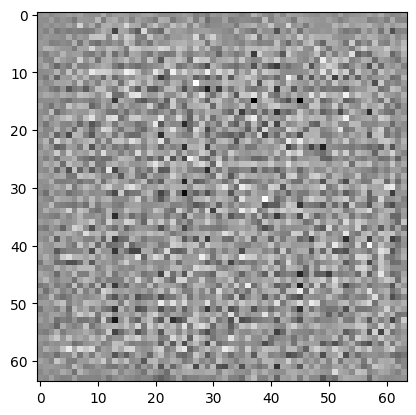

In [11]:
generator = make_generator_model()

# 1x100 tensor
noise = tf.random.normal([1, 100]) #batch_size = 1, 100 dimensional vector
generated_image = generator(noise, training=False) #generated image tensor

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator Model

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0003542]], shape=(1, 1), dtype=float32)


## Define Loss and Optimizers

In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#from_logits=True: This indicates that the input to the binary
#cross-entropy loss function consists of raw logits rather than probabilities.

### Disciminator Loss

In [15]:
def discriminator_loss(real_output, fake_output):
    # tf.ones_like(real_output) a tensor of ones with the same shape as real_output
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # tf.zeros_like(fake_output) a tensor of zeros with the same shape as fake_output
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator Loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Generator and Discriminator Optimizers

In [17]:
# The discriminator and the generator optimizers are different
# since you will train two networks separately.
# lr = 0.0001
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Funcion to save checkpoints

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

 # Save checkpoint every epoch
    # checkpoint.save(file_prefix=checkpoint_prefix)
# Restore
    # checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Training

### Define Training Loop

In [27]:
EPOCHS = 30
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [20]:
# `tf.function` annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Function to generate and save images

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Training steps

In [22]:
from math import ceil
def train(train_generator, epochs):
  for epoch in range(epochs):
    start = time.time()

    for i in range(ceil(BUFFER_SIZE / BATCH_SIZE)):
      image_batch = train_generator.next()
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 3 epochs
    if (epoch + 1) % 3 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

### Train the Model

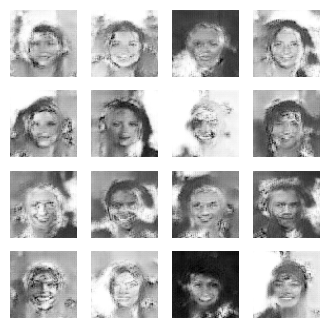

In [30]:
train(train_generator, EPOCHS)

In [34]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpoints/ckpt-4'

In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create GIF

In [25]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

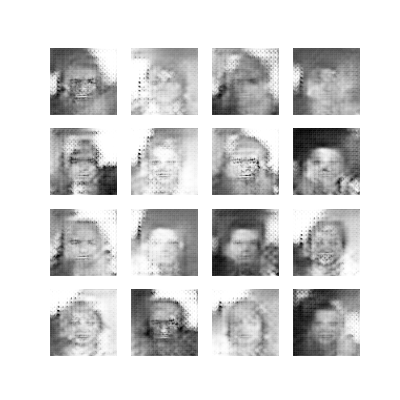

In [26]:
display_image(EPOCHS)

In [33]:
import imageio
import PIL

# Assuming you have images from epoch 0 to 99
images = []
for epoch_no in range(1,31):
    images.append(display_image(epoch_no))

imageio.mimsave('animation.gif', images, fps=10)